In [ ]:
!pip install uv==0.5.0
!pip install -e .. --quiet


In [ ]:
# !pip install -e /home/jovyan/Robbi/pyTMD

In [1]:
%load_ext autoreload
%autoreload 2

import odc.stac
import pandas as pd
import pystac_client

from pyTMD.compute import tide_elevations
import pandas as pd
import numpy as np


GAUGE_X = 122.2183
GAUGE_Y = -18.0008
ENSEMBLE_MODELS = ["EOT20", "HAMTIDE11"]  # simplified for tests

## Load fixtures

In [ ]:
def load_satellite_ds():
    """
    Load a sample timeseries of Landsat 8 data using odc-stac
    """
    # Connect to stac catalogue
    catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

    # Set cloud defaults
    odc.stac.configure_rio(
        cloud_defaults=True,
        aws={"aws_unsigned": True},
    )

    # Build a query with the parameters above
    buffer = 0.08
    # buffer = 0.5
    bbox = [GAUGE_X - buffer, GAUGE_Y - buffer, GAUGE_X + buffer, GAUGE_Y + buffer]
    query = catalog.search(
        bbox=bbox,
        collections=["ga_ls8c_ard_3"],
        datetime="2020-01/2020-02",
    )

    # Search the STAC catalog for all items matching the query
    ds = odc.stac.load(
        list(query.items()),
        bands=["nbart_red"],
        crs="epsg:3577",
        resolution=30,
        groupby="solar_day",
        bbox=bbox,
        fail_on_error=False,
        chunks={"x": 100, "y": 200},
    )

    return ds

satellite_ds = load_satellite_ds()

def load_measured_tides_ds():
    """
    Load measured sea level data from the Broome ABSLMP tidal station:
    http://www.bom.gov.au/oceanography/projects/abslmp/data/data.shtml
    """
    # Metadata for Broome ABSLMP tidal station:
    # http://www.bom.gov.au/oceanography/projects/abslmp/data/data.shtml
    ahd_offset = -5.322

    # Load measured tides from ABSLMP tide gauge data
    measured_tides_df = pd.read_csv(
        "../tests/data/IDO71013_2020.csv",
        index_col=0,
        parse_dates=True,
        na_values=-9999,
    )[["Sea Level"]]

    # Update index and column names
    measured_tides_df.index.name = "time"
    measured_tides_df.columns = ["tide_height"]

    # Apply station AHD offset
    measured_tides_df += ahd_offset

    # Return as xarray dataset
    return measured_tides_df.to_xarray()

satellite_ds = load_satellite_ds()
measured_tides_ds = load_measured_tides_ds()

## Run tests

In [ ]:
cd ..

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_model.py --verbose -k test_parallel_splits

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests --verbose

## `_standardise_models`

In [ ]:
from eo_tides.utils import _set_directory, list_models

directory = "/home/jovyan/Robbi/eo-tides/tests/data/tide_models/"
directory = _set_directory(directory)


# def _standardise_models(model, directory, ensemble_models=None):

#     # Turn inputs into arrays for consistent handling
#     models_requested = list(np.atleast_1d(model))

#     # Get full list of supported models from pyTMD database
#     available_models, valid_models = list_models(
#         directory, show_available=False, show_supported=False, raise_error=True
#     )
#     custom_options = ["ensemble", "all"]

#     # Error if any models are not supported
#     if not all(m in valid_models + custom_options for m in models_requested):
#         error_text = (
#             f"One or more of the requested models are not valid:\n"
#             f"{models_requested}\n\n"
#             "The following models are supported:\n"
#             f"{valid_models}"
#         )
#         raise ValueError(error_text)

#     # Error if any models are not available in `directory`
#     if not all(m in available_models + custom_options for m in models_requested):
#         error_text = (
#             f"One or more of the requested models are valid, but not available in `{directory}`:\n"
#             f"{models_requested}\n\n"
#             f"The following models are available in `{directory}`:\n"
#             f"{available_models}"
#         )
#         raise ValueError(error_text)

#     # If "all" models are requested, update requested list to include available models
#     if "all" in models_requested:
#         models_requested = available_models + [
#             m for m in models_requested if m != "all"
#         ]

#     # If "ensemble" modeling is requested, use custom list of ensemble models
#     if "ensemble" in models_requested:
#         print("Running ensemble tide modelling")
#         ensemble_models = (
#             ensemble_models
#             if ensemble_models is not None
#             else [
#                 "FES2014",
#                 "TPXO9-atlas-v5",
#                 "EOT20",
#                 "HAMTIDE11",
#                 "GOT4.10",
#                 "FES2012",
#                 "TPXO8-atlas-v1",
#             ]
#         )

#         # Error if any ensemble models are not available in `directory`
#         if not all(m in available_models for m in ensemble_models):
#             error_text = (
#                 f"One or more of the requested ensemble models are not available in `{directory}`:\n"
#                 f"{ensemble_models}\n\n"
#                 f"The following models are available in `{directory}`:\n"
#                 f"{available_models}"
#             )
#             raise ValueError(error_text)

#         # Return set of all ensemble plus any other requested models
#         models_to_process = ensemble_models + [
#             m for m in models_requested if m != "ensemble"
#         ]

#     # Otherwise, models to process are the same as those requested
#     else:
#         models_to_process = models_requested

#     # Remove duplicates
#     models_to_process = list(set(models_to_process))
#     models_requested = list(set(models_requested))

#     return models_to_process, models_requested, ensemble_models


# model = "EOT20"
# # model = ["EOT20", "HAMTIDE11"]  # = ["EOT20", "FES2014"]
# # model = "all"  # = [list all available]
# # model = "ensemble" # = [list all ensemble]
# # model = ["ensemble", "GOT5.5"]  # = [list all ensemble]
# # model = ["all", "ensemble"]


from eo_tides.utils import _standardise_models


model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["EOT20"],
    None,
    ["EOT20"],
    ["EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    "EOT20",
    None,
    ["EOT20"],
    ["EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    "all",
    None,
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["all"],
    None,
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    "ensemble",
    ["EOT20", "HAMTIDE11"],
    ["HAMTIDE11", "EOT20"],
    ["ensemble"],
    ["EOT20", "HAMTIDE11"],
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["ensemble"],
    ["EOT20", "HAMTIDE11"],
    ["HAMTIDE11", "EOT20"],
    ["ensemble"],
    ["EOT20", "HAMTIDE11"],
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["ensemble", "GOT5.5"],
    ["EOT20", "HAMTIDE11"],
    ["EOT20", "GOT5.5", "HAMTIDE11"],
    ["GOT5.5", "ensemble"],
    ["EOT20", "HAMTIDE11"],
)
# model, ensemble_models, exp_process, exp_request, exp_ensemble = (
#     ["all", "ensemble"],
#     ["EOT20", "HAMTIDE11"],
#     ["EOT20", "GOT5.5", "HAMTIDE11"],
#     ["GOT5.5", "HAMTIDE11", "ensemble", "EOT20"],
#     ["EOT20", "HAMTIDE11"],
# )


models_to_process, models_requested, ensemble_models = _standardise_models(
    model=model,
    directory=directory,
    ensemble_models=ensemble_models,
)

print("Models to process: ", models_to_process)
print("Models requested: ", models_requested)
print("Ensemble models: ", ensemble_models)

assert models_to_process == exp_process
assert models_requested == exp_request
assert ensemble_models == exp_ensemble

In [ ]:
models_requested

In [ ]:
list(set(models_requested + ensemble_models))

In [ ]:
ensemble_models

models_requested

## Custom consistuents

In [54]:
port = "62440"

file_path = f"/home/jovyan/Robbi/eo-tides/tests/data/{port}_Equi.txt"

df = pd.read_csv(file_path,
                 skiprows=15,
                 sep='\s+',
                 skipinitialspace=True,
                 parse_dates={'datetime': ['Date', 'Time']},
                 dayfirst=True,
                 engine='python')

df

/tmp/ipykernel_412/989775641.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path,


,datetime,Height(m)
0,2025-01-01 00:00:00,1.16
1,2025-01-01 01:00:00,1.58
2,2025-01-01 02:00:00,1.93
3,2025-01-01 03:00:00,2.15
4,2025-01-01 04:00:00,2.17
...,...,...
8755,2025-12-31 19:00:00,0.65
8756,2025-12-31 20:00:00,0.87
8757,2025-12-31 21:00:00,1.14
8758,2025-12-31 22:00:00,1.42


Modelling tides with FES2022
Converting to a wide format dataframe


<Axes: xlabel='AusTides_app', ylabel='AusTides_modelled'>

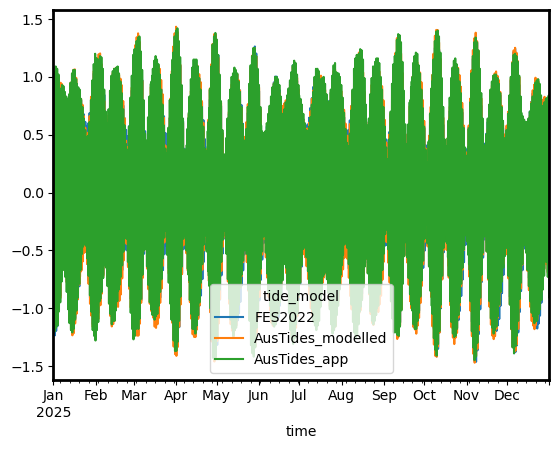

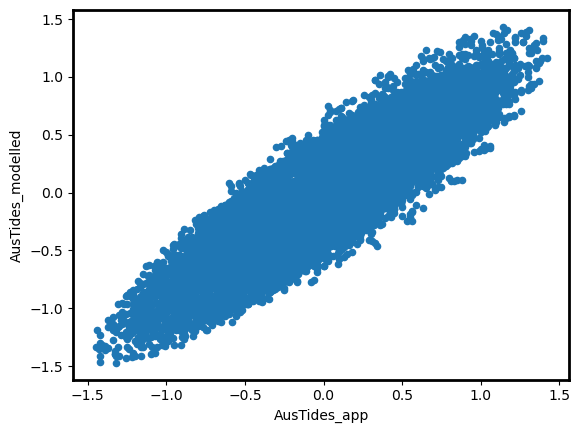

In [57]:
import pandas as pd
import numpy as np
import io
import pyTMD
from pyTMD.io.constituents import constituents
from eo_tides.utils import _standardise_time
from eo_tides.model import model_tides


def extract_constants_austides(file_path):
    """
    Parse harmonic constants from an AusTide harmonic constants file.
    """
    # Open file containing harmonic constants
    with open(file_path, "r") as f:
        text = f.read()

    # Break into sections
    sections = text.split("\n\n")

    # Find section containing LAT and LONG
    coord_section = next(s for s in sections if "LAT" in s and "LONG" in s)
    parts = coord_section.split()

    # Convert to decimal degrees (assuming parts will be:
    # ['Time', 'Zone', '−0800', 'LAT', '-18', '0', 'LONG', '122', '13'])
    lat = float(parts[4]) + float(parts[5]) / 60
    lon = float(parts[7]) + float(parts[8]) / 60

    # Find section containing MSL datum
    levels_section = next(s for s in sections if 'TIDAL LEVELS' in s)
    msl_line = next(line for line in levels_section.split('\n') if 'MSL' in line)
    msl = float(msl_line.split()[-1])

    # Find section containing constituents
    harmonic_idx = sections.index("HARMONIC CONSTANTS")
    data_text = sections[harmonic_idx + 2]

    # Read constituents
    constant_df = pd.read_csv(
        io.StringIO(data_text),
        sep="\s+",
        names=["c", "amp", "ph"],
    )

    # Rename constants to match pyTMD conventions
    c = [constituents.parse(i) for i in constant_df.c]

    # Reshape extracted constituents and convert to
    # masked arrays to for pyTMD compatability
    amp = np.expand_dims(constant_df.amp, axis=0)
    ph = np.expand_dims(constant_df.ph, axis=0)
    amp = np.ma.array(amp, mask=False)
    ph = np.ma.array(ph, mask=False)

    # Return constants and lat/lon coords
    return amp, ph, c, lon, lat, msl


# Input params
# time = pd.date_range("2020-01", "2020-02", freq="3h")
time = df.datetime
austides_path = f"/home/jovyan/Robbi/eo-tides/tests/data/{port}_HCons.txt"

# Extract AusTides constants
amp, ph, c, lon, lat, msl = extract_constants_austides(austides_path)

# Model tides with `eo-tides` and a global model
model = "FES2022"
tides_df = model_tides(
    x=lon,
    y=lat,
    time=time,
    model=model,
    directory="/var/share/tide_models/",
    output_format="wide",
)

# Standardise time to numpy datetime64 format
time = _standardise_time(time)

# Convert datetime
timescale = pyTMD.time.timescale().from_datetime(time.flatten())

# Calculate complex phase in radians for Euler's
cph = -1j * ph * np.pi / 180.0

# Calculate constituent oscillation
hc = amp * np.exp(cph)

# Convert datetime
deltat = np.zeros_like(timescale.tt_ut1)
# deltat = timescale.tt_ut1
t = timescale.tide

# Create arrays to hold outputs
tide = np.ma.zeros((len(t)), fill_value=np.nan)
tide.mask = np.any(hc.mask, axis=1)

# Predict tides
tide.data[:] = pyTMD.predict.time_series(
    t,
    hc,
    c,
    deltat=deltat,
)
# tides_df["AusTides"] = tide.data

minor = pyTMD.predict.infer_minor(
    t,
    hc,
    c,
    deltat=deltat,
    # corrections=pytmd_model.corrections,
    # minor=pytmd_model.minor,
)
tide.data[:] += minor.data[:]


# Add modelled AusTides to original dataframe
tides_df["AusTides_modelled"] = tide.data
tides_df["AusTides_app"] = df["Height(m)"].values - msl

# Plot
tides_df.droplevel(["x", "y"]).plot()
tides_df.droplevel(["x", "y"]).plot.scatter("AusTides_app", "AusTides_modelled")

In [58]:
np.sqrt((tides_df.subtract(tides_df.AusTides_app, axis=0) ** 2).mean())

tide_model
FES2022              0.318384
AusTides_modelled    0.286447
AusTides_app         0.000000
dtype: float64

In [13]:
minor = pyTMD.predict.infer_minor(
    t,
    hc,
    c,
    deltat=deltat,
    corrections="fes",
    # corrections=pytmd_model.corrections,
    # minor=pytmd_model.minor,
)
tide.data[:] += minor.data[:]

In [14]:
minor.max()

0.29222521275270624

<Axes: xlabel='AusTides', ylabel='AusTides_app'>

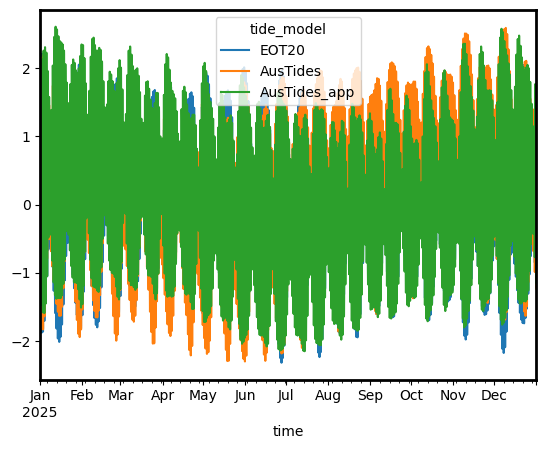

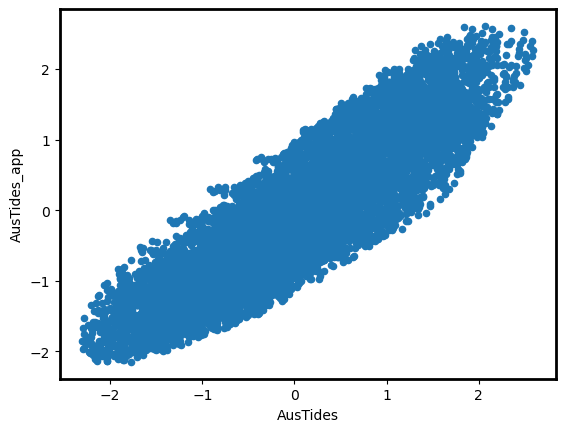

In [15]:
# Add modelled AusTides to original dataframe
tides_df["AusTides"] = tide.data
tides_df["AusTides_app"] = df["Height(m)"].values - 2.41

# Plot
tides_df.droplevel(["x", "y"]).plot()
tides_df.droplevel(["x", "y"]).plot.scatter("AusTides", "AusTides_app")

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(tides_austide, tides_fes2014, s=0.1, alpha=0.5)
plt.xlabel("AusTides")
plt.xlabel("FES")

In [ ]:
import pyTMD
from eo_tides.utils import _standardise_time

time = _standardise_time(pd.date_range("2020", "2021", periods=10))
# from pyTMD.time import convert_datetime
# from pyTMD.time import timescale

import timescale.time

# standard epochs
_mjd_epoch = (1858, 11, 17, 0, 0, 0)
_ntp_epoch = (1900, 1, 1, 0, 0, 0)
_unix_epoch = (1970, 1, 1, 0, 0, 0)
_gps_epoch = (1980, 1, 6, 0, 0, 0)
_tide_epoch = (1992, 1, 1, 0, 0, 0)
_j2000_epoch = (2000, 1, 1, 12, 0, 0)
_atlas_sdp_epoch = (2018, 1, 1, 0, 0, 0)

timescale.time.convert_datetime(time, epoch=_tide_epoch)


In [ ]:
timescale.time.convert_delta_time

In [ ]:
pyTMD.time.timescale().from_datetime(time.flatten())

In [ ]:
timescale.time.convert_delta_time(*args, **kwargs)

In [ ]:
timescale.gmst

In [ ]:
timescale.tide

In [ ]:
timescale.to_deltatime(epoch=_tide_epoch)

In [ ]:
timescale.tt_ut1

In [ ]:
timescale.tt

In [ ]:
pyTMD.predict.time_series(
        deltat,
        hc,
        c,
        # deltat=deltat.flatten(),
        # corrections=pytmd_model.corrections,
    )

In [ ]:
import pyTMD

x=np.array(122.244532)
y=np.array(-17.963583)
time=time
model="FES2014"
directory="/var/share/tide_models/"


# Obtain model details
pytmd_model = pyTMD.io.model(directory).elevation(model)

# Reproject x, y to latitude/longitude
# transformer = pyproj.Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
# lon, lat = transformer.transform(x.flatten(), y.flatten())
lon = [x]
lat = [y]

# Convert datetime
timescale = pyTMD.time.timescale().from_datetime(time.flatten())

# Read tidal constants and interpolate to grid points
amp_m, ph_m, c_m = pytmd_model.extract_constants(
    lon,
    lat,
    type=pytmd_model.type,
    crop=True,
    # method=method,
    extrapolate=True,
    # cutoff=cutoff,
    # append_node=False,
    # append_node=True,
)

In [ ]:
test = pd.DataFrame({"c": c, "amp": amp.data[0,:], "ph": ph.data[0,:]}).sort_values("c").set_index("c")

In [ ]:
test_m = pd.DataFrame({"c": c_m, "amp": amp_m.data[0,:], "ph": ph_m.data[0,:]}).sort_values("c").set_index("c")

In [ ]:
test_joined = test.join(test_m, lsuffix="_austides", rsuffix="_fes2014").round(3)  #.plot.scatter(x="amp", y="amp_m")

In [ ]:
test_joined.ph_austides - test_joined.ph_fes2014

In [ ]:
amp.T

## Investigate interpolation functions

crop=True, bounds=None: 
crop=False, bounds=None:
crop=True, bounds=

In [ ]:
%%timeit -n 1 -r 1

x=np.linspace(122.2183, 122.219, 10)
y=np.linspace(-18.0008, -18.01, 10)
time=pd.date_range("2020", "2021", periods=10)
crs="EPSG:4326"
method="spline"
model="FES2022"

# Run equivalent pyTMD code to verify same results
pytmd_tides = tide_elevations(
        x=x, 
        y=y, 
        delta_time=time,
        DIRECTORY="/gdata1/data/tide_models/",
        MODEL=model,
        EPSG=int(crs[-4:]),
        TIME="datetime",
        EXTRAPOLATE=True,
        CUTOFF=np.inf,
        METHOD=method,
        CROP=True,
        # CROP=False,
        # BOUNDS=bounds,
        )
pytmd_tides

In [ ]:
pytmd_tides

In [ ]:
%load_ext line_profiler

from pyTMD.io.model import model
from pyTMD.io import FES
%lprun -u 1 -f FES.extract_constants tide_elevations(x=np.linspace(122.2183, 122.219, 2), y=np.linspace(-18.0008, -18.01, 2), delta_time=pd.date_range("2020", "2021", periods=2), DIRECTORY="/gdata1/data/tide_models/", MODEL="FES2022", EPSG=4326, TIME="datetime", EXTRAPOLATE=True, CUTOFF=np.inf, METHOD="spline", CROP=False)

In [ ]:
%load_ext line_profiler

from pyTMD.io.model import model
from pyTMD.io import FES
%lprun -u 1 -f FES.extract_constants tide_elevations(x=np.linspace(122.2183, 122.219, 2), y=np.linspace(-18.0008, -18.01, 2), delta_time=pd.date_range("2020", "2021", periods=2), DIRECTORY="/gdata1/data/tide_models/", MODEL="FES2022", EPSG=4326, TIME="datetime", EXTRAPOLATE=True, CUTOFF=np.inf, METHOD="linear", CROP=False)

In [ ]:
%load_ext line_profiler

from pyTMD.io.model import model
from pyTMD.io import FES
%lprun -u 1 -f FES.extract_constants tide_elevations(x=np.linspace(122.2183, 122.219, 2), y=np.linspace(-18.0008, -18.01, 2), delta_time=pd.date_range("2020", "2021", periods=2), DIRECTORY="/gdata1/data/tide_models/", MODEL="FES2022", EPSG=4326, TIME="datetime", EXTRAPOLATE=True, CUTOFF=np.inf, METHOD="spline", CROP=True, BOUNDS=[121.218, 123.218, -19.000, -17.000])

In [ ]:


from __future__ import print_function, annotations

import logging
import pathlib
import numpy as np
from io import IOBase
import scipy.interpolate
import pyTMD.crs
import pyTMD.io
import pyTMD.io.model
import pyTMD.predict
import pyTMD.spatial
import pyTMD.utilities
import timescale.eop
import timescale.time
# attempt imports
pyproj = pyTMD.utilities.import_dependency('pyproj')


x, y, crs, method, model = -1034913, -1961916, "EPSG:3577", "bilinear", "EOT20"

x=x
y=y
delta_time=measured_tides_ds.time
DIRECTORY="/var/share/tide_models/"
MODEL=model
EPSG=int(crs[-4:])
TIME="datetime"
EXTRAPOLATE=True
CUTOFF=np.inf
CROP=True
METHOD=method

GZIP=False
DEFINITION_FILE=None
BOUNDS=None
EPOCH=(2000, 1, 1, 0, 0, 0)
TYPE='drift'
CORRECTIONS = None
INFER_MINOR = True
MINOR_CONSTITUENTS = None
APPEND_NODE = False
APPLY_FLEXURE= False
FILL_VALUE=np.nan



# check that tide directory is accessible
if DIRECTORY is not None:
    DIRECTORY = pathlib.Path(DIRECTORY).expanduser()
    if not DIRECTORY.exists():
        raise FileNotFoundError("Invalid tide directory")

# validate input arguments
assert TIME.lower() in ('gps', 'loran', 'tai', 'utc', 'datetime')
assert METHOD.lower() in ('bilinear', 'spline', 'linear', 'nearest')

# get parameters for tide model
if DEFINITION_FILE is not None:
    model = pyTMD.io.model(DIRECTORY).from_file(DEFINITION_FILE)
else:
    model = pyTMD.io.model(DIRECTORY, compressed=GZIP).elevation(MODEL)

# determine input data type based on variable dimensions
if not TYPE:
    TYPE = pyTMD.spatial.data_type(x, y, delta_time)
assert TYPE.lower() in ('grid', 'drift', 'time series')
# reform coordinate dimensions for input grids
# or verify coordinate dimension shapes
if (TYPE.lower() == 'grid') and (np.size(x) != np.size(y)):
    x,y = np.meshgrid(np.copy(x),np.copy(y))
elif (TYPE.lower() == 'grid'):
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
elif TYPE.lower() in ('time series', 'drift'):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)

# converting x,y from EPSG to latitude/longitude
crs1 = pyTMD.crs().from_input(EPSG)
crs2 = pyproj.CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(crs1, crs2, always_xy=True)
lon, lat = transformer.transform(x.flatten(), y.flatten())

# verify that delta time is an array
delta_time = np.atleast_1d(delta_time)
# convert delta times or datetimes objects to timescale
if (TIME.lower() == 'datetime'):
    ts = timescale.time.Timescale().from_datetime(
        delta_time.flatten())
else:
    ts = timescale.time.Timescale().from_deltatime(delta_time,
        epoch=EPOCH, standard=TIME)
# number of time points
nt = len(ts)


In [ ]:
# read tidal constants and interpolate to grid points
amp, ph, c = model.extract_constants(lon, lat, type=model.type,
    crop=CROP, bounds=BOUNDS, method=METHOD,
    extrapolate=EXTRAPOLATE, cutoff=CUTOFF,
    append_node=APPEND_NODE, apply_flexure=APPLY_FLEXURE)

In [ ]:
amp

In [ ]:
ph

In [ ]:
# adjust dimensions of input coordinates to be iterable
ilon = np.atleast_1d(np.copy(lon))
ilat = np.atleast_1d(np.copy(lat))
# set default bounds if cropping
xmin, xmax = np.min(ilon), np.max(ilon)
ymin, ymax = np.min(ilat), np.max(ilat)
bounds=[xmin-1, xmax+1, ymin-1, ymax+1]


# read tidal constants and interpolate to grid points
c = model.read_constants(crop=True)

In [ ]:
c = model.read_constants(crop=False, bounds=bounds)
plt.imshow(c.m2.mask)

In [ ]:
c = model.read_constants(crop=True, bounds=bounds)
plt.imshow(c.m2.mask)

In [ ]:
plt.imshow(c.m2.astype("float32"))

In [ ]:
c.m2

In [ ]:
# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)

## Compare timings

In [ ]:
import time

from eo_tides.model import model_tides
import numpy as np
import pandas as pd

# Generate random data within input bounds
n = 2000
x = np.random.uniform(112.715430, 154.727149, n)
y = np.random.uniform(-44.199061, -10.035282, n)
times = pd.date_range("2020", "2021", periods=100)
model = "FES2014"
# directory = "/var/share/tide_models/"
directory = "/gdata1/data/tide_models/"

# Time the spline method
start_time = time.time()
modelled_tides_df_spline = model_tides(
   x=x,
   y=y,
   time=times,
   model=model,
   method="spline",
   directory=directory,
   parallel=False,
   crop=False, 
)
spline_time = time.time() - start_time

# Time the linear method  
start_time = time.time()
modelled_tides_df_linear = model_tides(
   x=x,
   y=y,
   time=times,
   model=model,
   method="linear",
   directory=directory,
   parallel=False,
   crop=False,
)
linear_time = time.time() - start_time

print(f"Spline method time: {spline_time:.6f} seconds")
print(f"Linear method time: {linear_time:.6f} seconds")

In [ ]:
import time

from eo_tides.model import model_tides
import numpy as np
import pandas as pd

# Generate random data within input bounds
n = 2000
x = np.random.uniform(112.715430, 154.727149, n)
y = np.random.uniform(-44.199061, -10.035282, n)
times = pd.date_range("2020", "2021", periods=100)
model = "FES2014"
# directory = "/var/share/tide_models/"
directory = "/gdata1/data/tide_models/"

# # Time the spline method
# start_time = time.time()
# modelled_tides_df_spline = model_tides(
#    x=x,
#    y=y,
#    time=times,
#    model=model,
#    method="spline",
#    directory=directory,
#    parallel=False,
#    crop=True, 
# )
# spline_time = time.time() - start_time

# Time the linear method  
start_time = time.time()
modelled_tides_df_linear = model_tides(
   x=x,
   y=y,
   time=times,
   model=model,
   method="linear",
   directory=directory,
   parallel=False,
   crop=True,
)
linear_time = time.time() - start_time

# print(f"Spline method time: {spline_time:.6f} seconds")
print(f"Linear method time: {linear_time:.6f} seconds")

In [ ]:
import time

from eo_tides.model import model_tides
import numpy as np
import pandas as pd

# Generate random data within input bounds
x = np.random.uniform(112.715430, 154.727149, 100000)
y = np.random.uniform(-44.199061, -10.035282, 100000)
times = pd.date_range("2020", "2021", periods=100)
# model = "EOT20"
# directory = "/var/share/tide_models/"
directory = "/gdata1/data/tide_models_clipped/"

output_list = []

for model in [["EOT20", "GOT5.5"], "EOT20"]:

    for n in [100, 1000, 10000, 100000]:
    
        # Select a subset of x and y
        x_sub = x[0:n]
        y_sub = y[0:n]
    
        for parallel_max in [2, 4, 8, 16]:
        
            for parallel_split in [1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20]:
        
                # Time the linear method
                start_time = time.time()
                modelled_tides_df_linear = model_tides(
                    x=x_sub,
                    y=y_sub,
                    time=times,
                    model=model,
                    method="linear",
                    directory=directory,
                    parallel=True,
                    parallel_splits=parallel_split,
                    parallel_max=parallel_max,
                    crop=True,
                )
                split_time = time.time() - start_time
        
                output_dict = {
                    "split": parallel_split,
                    "parallel_max": parallel_max,
                    "time": split_time,
                    "points": n,
                    "points_per_split": int(n / parallel_split),
                    "split_per_parallel": parallel_split / parallel_max,
                    "directory": directory,
                    "model": model,
                }
                output_list.append(output_dict)
                print(output_dict)


In [ ]:
# Combine and export
data = pd.DataFrame(output_list)
data["time_per_point"] = data["time"] / data["points"]
data["model_multiple"] = data["model"].apply(lambda x: x == ['EOT20', 'GOT5.5'])
data.to_csv("test_timings.csv", index=False)

In [ ]:
data = pd.read_csv("test_timings.csv")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the faceted plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='split', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[0], linewidth=3)
axes[0].set_title('Time by Split')

lineplot = sns.lineplot(x='points_per_split', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[1], linewidth=3)
lineplot.invert_xaxis()
axes[1].set_title('Time by Points per split')

plt.tight_layout()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the faceted plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='split', y='time', hue='parallel_max', data=data.query("model_multiple"), ax=axes[0], linewidth=3)
axes[0].set_title('Time by Split')

lineplot = sns.lineplot(x='points_per_split', y='time', hue='parallel_max', data=data.query("model_multiple"), ax=axes[1], linewidth=3)
lineplot.invert_xaxis()
axes[1].set_title('Time by Points per split')

plt.tight_layout()

In [ ]:
data["split_per_parallel"] = data["split"] / data["parallel_max"]

# Create the faceted plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='split', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[0], linewidth=3)
axes[0].set_title('Time by Split')

lineplot = sns.lineplot(x='split_per_parallel', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[1], linewidth=3)
axes[1].set_title('Time by Splits per parallel')

In [ ]:
data.query("model == 'EOT20'").query("parallel_max == 2").query("points == 10000").set_index("points_per_split").time_per_point.plot()

In [ ]:

parallel_max = 16
parallel_split="auto"

n = 200000
models = ["EOT20"]  # ["EOT20", "GOT5.5"]
# models = ["EOT20", "GOT5.5"]


# import os

# os.process_cpu_count()

parallel_split = int(max(1, min(n / 1000, parallel_max) / len(models)))
print(parallel_split, n/parallel_split)


In [ ]:
def _parallel_splits(
    total_points,
    model_count,
    parallel_max=None,
    min_points_per_split=1000,
):
    """
    Calculates the optimal number of parallel splits for data
    processing based on system resources and processing constraints.

    Parameters:
    -----------
    total_points : int
        Total number of data points to process
    model_count : int
        Number of models that will be run in parallel
    parallel_max : int, optional
        Maximum number of parallel processes to use. If None, uses CPU core count
    min_points_per_split : int, default=1000
        Minimum number of points that should be processed in each split
    """
    # Available CPUs
    if parallel_max is None:
        try:
            import psutil

            parallel_max = psutil.cpu_count(logical=False)
        except ImportError:
            parallel_max = os.cpu_count()

    # Calculate optimal number of splits based on constraints
    splits_by_size = total_points / min_points_per_split
    splits_by_cpu = parallel_max / model_count
    optimal_splits = min(splits_by_size, splits_by_cpu)

    # Convert to integer and ensure at least 1 split
    final_split_count = int(max(1, optimal_splits))
    return final_split_count


_parallel_splits(total_points=1, model_count=1, parallel_max=None)

In [ ]:
(10.6666)

In [ ]:
os.cpu_count(affinity=True)

In [ ]:
len(os.sched_getaffinity(0))

In [ ]:
# os.cpu_count()

# import multiprocessing

# multiprocessing.cpu_count()

In [ ]:
from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor(max_workers=None) as executor:
    executor.

In [ ]:
import time
from eo_tides.model import model_tides

n = 10000
directory = "/gdata1/data/tide_models_clipped/"
directory = "./tests/data/tide_models/"
# models = ["EOT20", "GOT5.5", "HAMTIDE11"]
models = ["EOT20"]


start_time = time.time()
modelled_tides_df_linear = model_tides(
    x = np.random.uniform(112.715430, 154.727149, n),
    y = np.random.uniform(-44.199061, -10.035282, n),
    time = pd.date_range("2020", "2021", periods=100),
    model=models,
    method="linear",
    directory=directory,
    parallel=True,
    parallel_splits="auto",
    parallel_max=16,
    crop=False,
)
split_time = time.time() - start_time
print(split_time)

In [ ]:
modelled_tides_df_linear

In [ ]:
# n = 10000
data.query("(points == @n) & (parallel_max == @parallel_max) & (~model_multiple)").style.background_gradient(cmap="YlOrRd", subset="time_per_point")

In [ ]:
data.pivot(columns="model_multiple", values="time")

In [ ]:
data.query("(points == @n) & (parallel_max == @parallel_max) & (model_multiple)").time.plot.hist()

In [ ]:
data.query("(points == @n) & (parallel_max == @parallel_max) & (~model_multiple)").time.plot.hist()

In [ ]:
plt.scatter(modelled_tides_df_spline.droplevel(["x", "y"]).tide_height, modelled_tides_df_linear.droplevel(["x", "y"]).tide_height)

In [ ]:
# # Run equivalent pyTMD code to verify same results
# pytmd_tides_spline = tide_elevations(
#         x=np.repeat(149.722622, len(measured_tides_ds.time)), 
#         y=np.repeat(-22.132984, len(measured_tides_ds.time)), 
#         delta_time=measured_tides_ds.time,
#         DIRECTORY="/var/share/tide_models/",
#         MODEL="FES2012",
#         EPSG=4326,
#         TIME="datetime",
#         EXTRAPOLATE=True,
#         CUTOFF=np.inf,
#         METHOD="spline",
#         CROP=True,
#         # BOUNDS=[148.722622, 149.722622, -22.132984, -23.132984],
#         )

pytmd_tides_linear = tide_elevations(
        x=np.repeat(149.722622, len(measured_tides_ds.time)), 
        y=np.repeat(-22.132984, len(measured_tides_ds.time)), 
        delta_time=measured_tides_ds.time,
        DIRECTORY="/var/share/tide_models/",
        MODEL="TPXO9-atlas-v5-nc",
        EPSG=4326,
        TIME="datetime",
        EXTRAPOLATE=True,
        CUTOFF=np.inf,
        METHOD="linear",
        CROP=True,
        # BOUNDS=[140.002622, 149.722622, -23.132984, -22.132984],
        )

In [ ]:
pytmd_tides_linear

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(pytmd_tides_spline.data, pytmd_tides_linear.data)

In [ ]:
phase_df = phase_tides(
    x=[122.14],
    y=[-17.91],
    time=pd.date_range("2020-01-01", "2020-01-02", freq="h"),
    directory="/var/share/tide_models/",
    model=["EOT20"],
    delta = "15 min",
)

In [ ]:
import pandas as pd
pd.date_range(start="2000-01-01", end="2000-01-02", periods=3).values

In [ ]:
x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "bilinear", "EOT20"

In [ ]:
x, y

## Testing pyTMD

In [ ]:
from eo_tides import model_tides

x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "spline", "EOT20"
x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "bilinear", "EOT20"
x, y, crs, method, model = -1034913, -1961916, "EPSG:3577", "bilinear", "EOT20"


# # Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    time=measured_tides_ds.time,
    crs=crs,
    method=method,
    directory="./tests/data/tide_models",
    # crop=False,
)

# Run equivalent pyTMD code to verify same results
pytmd_tides = tide_elevations(
        x=x, 
        y=y, 
        delta_time=measured_tides_ds.time,
        DIRECTORY="./tests/data/tide_models",
        MODEL=model,
        EPSG=int(crs[-4:]),
        TIME="datetime",
        EXTRAPOLATE=True,
        CUTOFF=np.inf,
        METHOD=method,
        # CORRECTIONS: str | None = None,
        # INFER_MINOR: bool = True,
        # MINOR_CONSTITUENTS: list | None = None,
        # APPLY_FLEXURE: bool = False,
        # FILL_VALUE: float = np.nan
        # APPEND_NODE=True,
        )

np.allclose(modelled_tides_df.tide_height.values, pytmd_tides.data)

In [ ]:
pytmd_tides

## Appending node

In [ ]:
from eo_tides import model_tides

x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "spline", "EOT20"
x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "bilinear", "EOT20"
x, y, crs, method, model = -1034913, -1961916, "EPSG:3577", "bilinear", "EOT20"


# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    model="FES2014",
    time=pd.date_range("1980", "2020", freq="9h"),
    crs=crs,
    method=method,
    directory="/var/share/tide_models/",
)

In [ ]:
# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df2 = model_tides(
    x=[x],
    y=[y],
    model="FES2014",
    time=pd.date_range("1980", "2020", freq="9h"),
    crs=crs,
    method=method,
    directory="/var/share/tide_models/",
)

In [ ]:
modelled_tides_df.tide_height.plot(alpha=0.5)

In [ ]:
modelled_tides_df2.tide_height - modelled_tides_df.tide_height

### Error for out of bounds

In [ ]:
from eo_tides import model_tides

x, y = 180, -50


# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    model=["EOT20", "GOT5.5"],
    time=measured_tides_ds.time,
    directory="../tests/data/tide_models",
)

In [ ]:
from eo_tides import list_models
list_models(directory="")

## Stats bug

In [ ]:
from eo_tides.stats import pixel_stats

In [ ]:
models = ["EOT20"]
resample = False

stats_ds = pixel_stats(
    ds=satellite_ds,
    model=models,
    resample=resample,
    directory="../tests/data/tide_models",
)

In [ ]:
stats_ds

### Modelling ebb and flow tidal phases
The `tag_tides` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`. This is achieved by comparing tide heights 15 minutes before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

Once you run the cell below, our data will now also contain a new `ebb_flow` variable under **Data variables**:

In [ ]:
import datacube

dc = datacube.Datacube()

ds = dc.load(product="ga_s2ls_intertidal_cyear_3", limit=1, measurements="elevation")

In [ ]:
from odc.geo.geobox import GeoBox
import xarray as xr
import textwrap
import numpy as np

from typing import Any


def _standardise_time(
    time: np.ndarray | pd.DatetimeIndex | pd.Timestamp | None,
) -> np.ndarray | None:
    """
    Accept a datetime64 ndarray, pandas.DatetimeIndex
    or pandas.Timestamp, and return a datetime64 ndarray.
    """
    # Return time as-is if none
    if time is None:
        return time

    # Convert to a 1D datetime64 array
    time = np.atleast_1d(time).astype("datetime64[ns]")

    return time


def _standardise_inputs(
    ds: xr.DataArray | xr.Dataset | GeoBox,
    time: np.ndarray | pd.DatetimeIndex | pd.Timestamp | None,
) -> (GeoBox, np.ndarray):
    """
    Takes an xarray or GeoBox input and an optional custom times,
    and returns a standardised GeoBox and  
    """

    # If `ds` is an xarray object, extract its GeoBox and time
    if isinstance(ds, (xr.DataArray, xr.Dataset)):

        # Try to extract GeoBox
        try:
            gbox = ds.odc.geobox
        except AttributeError:
            error_msg = """
            Cannot extract a valid GeoBox for `ds`. This is required for
            extracting details about `ds`'s CRS and spatial location.
            
            Import `odc.geo.xr` then run `ds = ds.odc.assign_crs(crs=...)`
            to prepare your data before passing it to this function.
            """
            raise Exception(textwrap.dedent(error_msg).strip())

        # Use custom time by default if provided; otherwise try and extract from `ds`
        if time is not None:
            time = _standardise_time(time)
        elif "time" in ds.coords:
            time = ds.coords["time"].values
        else:
            raise ValueError(
                "`ds` does not have a time dimension, and no custom times were provided via `time`."
            )

    # If `ds` is a GeoBox, use it directly; raise an error if no time was provided
    elif isinstance(ds, GeoBox):
        gbox = ds
        if time is not None:
            time = _standardise_time(time)
        else:
            raise ValueError("If `ds` is a GeoBox, `time` must be provided.")

    # Raise error if no valid inputs were provided
    else:
        raise TypeError(
            "`ds` must be an xarray.DataArray, xarray.Dataset, or odc.geo.geobox.GeoBox."
        )

    return gbox, time


time = pd.date_range("2021", "2022").values
time = pd.date_range("2021", "2022")
time = pd.Timestamp("2022-02-01")
# time = satellite_ds.time
# time = ["a", "b"]


gbox, time = _standardise_inputs(ds=ds.drop_dims("time").odc.geobox, time=time)
gbox, time

In [ ]:
satellite_ds.chunks["x"]

In [ ]:
import pandas as pd

time = pd.date_range("2021", "2022").values
# time = pd.date_range("2021", "2022")
# time = pd.Timestamp("2022-02-01")
time = satellite_ds.time


def _standardise_time(
    time: np.ndarray | pd.DatetimeIndex | pd.Timestamp | None,
) -> np.ndarray | None:
    """
    Accept a datetime64 ndarray, pandas.DatetimeIndex
    or pandas.Timestamp, and return a datetime64 ndarray.
    """
    # Return time as-is if none
    if time is None:
        return time

    # Convert to a 1D datetime64 array
    time = np.atleast_1d(time).astype("datetime64[ns]")

    return time


time = pd.date_range("2021", "2022").values
# time = pd.date_range("2021", "2022")
# time = pd.Timestamp("2022-02-01")
# time = satellite_ds.time
# time = [pd.Timestamp("2022-02-01"), pd.Timestamp("2022-02-01")]
# time = None
_standardise_time(time=time)

In [ ]:
test = np.atleast_1d(time).astype('datetime64[ns]')

In [ ]:
test

In [ ]:
ds = ds.odc.assign_crs("EPSG:3577")

In [ ]:
test = satellite_ds.nbart_red.drop_attrs(deep=True).drop_vars("spatial_ref").odc.reload()

In [ ]:
test  #odc.reload()

In [ ]:
# Model tide heights
ds = tag_tides(
    ds, 
    ebb_flow=True,     
    directory="../../tests/data/tide_models",
)

# Print output data
print(ds)

We now have data giving us the both the tide height and tidal phase ("ebb" or "flow") for every satellite image:

In [ ]:
ds[["time", "tide_height", "ebb_flow"]].drop_vars("spatial_ref").to_dataframe().head()

We could for example use this data to filter our observations to keep ebbing phase observations only:

In [ ]:
ds_ebb = ds.where(ds.ebb_flow == "Ebb", drop=True)
print(ds_ebb)

## Pixel biases

In [ ]:
import odc.stac
import pystac_client
import planetary_computer

# Connect to STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["sentinel-2-l2a"],
    datetime="2021/2023",
)

# Load data into xarray format
ds_s2 = odc.stac.load(
    items=list(query.items()),
    bands=["red"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds_s2)

In [ ]:
list(stats_ds.data_vars.keys())

In [ ]:
from eo_tides.stats import pixel_stats

models = ["EOT20"]
resample = True

stats_ds = pixel_stats(
    ds=satellite_ds,
    model=models,
    resample=resample,
    directory="../tests/data/tide_models",
)

# Verify dims are correct
assert stats_ds.odc.spatial_dims == satellite_ds.odc.spatial_dims

# Verify vars are as expected
expected_vars = ['hat',  'hot',  'lat',  'lot',  'otr',  'tr',  'spread',  'offset_low',  'offset_high']
assert set(expected_vars) == set(stats_ds.data_vars)

# Verify tide models are correct
assert all(stats_ds["tide_model"].values == models)
if len(models) > 1:
    assert "tide_model" in stats_ds.dims

# If resample, assert that statistics have the same shape and dims
# as `satellite_ds`
if resample:
    assert satellite_ds.odc.geobox.shape == stats_ds.odc.geobox.shape



In [ ]:
# Verify values are roughly expected
assert np.allclose(stats_ds.offset_high.mean().item, 0.30, atol=0.02)
assert np.allclose(stats_ds.offset_low.mean().item, 0.27, atol=0.02)
assert np.allclose(stats_ds.spread.mean().item, 0.43, atol=0.02)

In [ ]:
stats_ds.offset_high.mean().item()

In [ ]:
stats_ds.spread.mean()

In [ ]:
stats_ds["tide_model"].values.tolist()

In [ ]:
stats_ds["tide_model"].values.tolist()

In [ ]:
set(['hat',  'hot',  'lat',  'lot',  'otr',  'tr',  'spread',  'offset_low',  'offset_high'])

In [ ]:
set(stats_ds.data_vars)

In [ ]:
from eo_tides import pixel_tides

pixel_tides(
    ds=satellite_ds,
    model=["EOT20", "GOT5.5"],
    directory="../tests/data/tide_models",
    )

In [ ]:
stats_ds.dims

In [ ]:
satellite_ds.x